In [1]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np
import seaborn as sns
import scipy

# **Dataset Amazon Top 50 Bestselling Books 2009 - 2022**

Il dataset contiene i 50 libri best seller per anno dal 2009 al 2022

In [2]:
book = pd.read_csv('bestsellers.csv') 
book.head()

,Name,Author,User Rating,Reviews,Price,Year,Genre
0,"Act Like a Lady, Think Like a Man: What Men Re...",Steve Harvey,4.6,5013,17,2009,Non Fiction
1,Arguing with Idiots: How to Stop Small Minds a...,Glenn Beck,4.6,798,5,2009,Non Fiction
2,"Breaking Dawn (The Twilight Saga, Book 4)",Stephenie Meyer,4.6,9769,13,2009,Fiction
3,Crazy Love: Overwhelmed by a Relentless God,Francis Chan,4.7,1542,14,2009,Non Fiction
4,Dead And Gone: A Sookie Stackhouse Novel (Sook...,Charlaine Harris,4.6,1541,4,2009,Fiction


Da una lettura preliminare del dataset attraverso la funzione head possiamo già capire che si potrà lavorare ad esempio sul campo "genre" che assume solo due tipi (fiction e non fiction) e capirne la correlazione con gli anni, le valutazioni ecc. ecc.

Estraiamo informazioni di base sul nostro dataset.

In [3]:
book.describe()

,User Rating,Reviews,Price,Year
count,700.000000,700.000000,700.000000,700.000000
mean,4.639857,19255.195714,12.700000,2015.500000
std,0.218586,23613.443875,9.915162,4.034011
min,3.300000,37.000000,0.000000,2009.000000
25%,4.500000,4987.250000,7.000000,2012.000000
50%,4.700000,10284.000000,11.000000,2015.500000
75%,4.800000,23358.000000,15.000000,2019.000000
max,4.900000,208917.000000,105.000000,2022.000000


Controllo se ci sono colonne con elementi vuoti, come vedremo non ci sono e quindi non dovrò eseguire funzioni di riempimento automatico

In [4]:
book.isnull().sum()

Name           0
Author         0
User Rating    0
Reviews        0
Price          0
Year           0
Genre          0
dtype: int64

quanti dati e quante caratteristiche abbiamo a disposizione?

In [5]:
book.shape

(700, 7)

Dall'output della funzione shape capiamo che le colonne sono 7 (informazione già conosciuta) e che il numero di righe e cioè libri nel dataset è 700

Adesso calcoliamo la correlazione

In [6]:
book.corr()

,User Rating,Reviews,Price,Year
User Rating,1.000000,0.080423,-0.157253,0.286601
Reviews,0.080423,1.000000,-0.114554,0.494279
Price,-0.157253,-0.114554,1.000000,-0.155266
Year,0.286601,0.494279,-0.155266,1.000000


## REVIEWES NEGLI ANNI

Come immaginabile la correlazione tra dati che si nota maggiormente è quella Reviewes - Year e quella User Rating - Year. Questo probabilmente perchè col passare degli anni e con la crescita della popolarità di amazon anche il numero di utenti che lasciano valutazioni e reviews è aumentato.
Di seguito un grafico lineare che dimostra quello appena detto:

In [7]:
annual_reviews = book.groupby('Year')[['Reviews']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_reviews)

    Year   Reviews
0   2009   4710.12
1   2010   5479.62
2   2011   8100.82
3   2012  13090.92
4   2013  13098.14
5   2014  15859.94
6   2015  14233.38
7   2016  14196.00
8   2017  12888.40
9   2018  13930.42
10  2019  15898.34
11  2020  52349.94
12  2021  44859.48
13  2022  40877.22


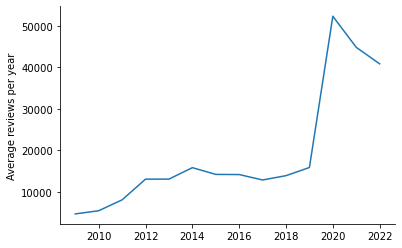

In [8]:
fig, ax = plt.subplots()
plt.plot(annual_reviews['Year'], annual_reviews['Reviews'])
plt.ylabel('Average reviews per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Anche usando un grafico più utilizzato nel corso possiamo notare come negli ultimi anni (soprattutto dopo il 2018) c'è stato un aumento significativo delle reviews

<AxesSubplot:xlabel='Year', ylabel='Reviews'>

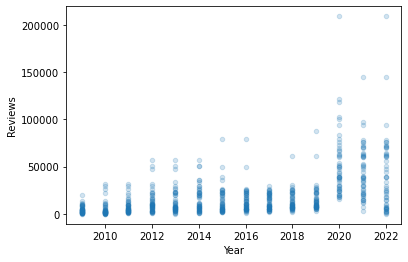

In [9]:
book.plot(kind= 'scatter', x= 'Year', y= 'Reviews', alpha= 0.2)

Guardiamo il dataset rappresentandolo con alcuni grafici:

<BarContainer object of 5 artists>

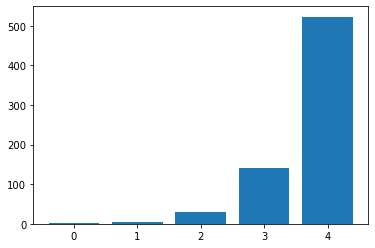

In [10]:
histo = np.histogram(book['User Rating'],bins=5)
plt.bar(x=np.asarray(range(5)),height=histo[0])

Come possiamo immaginare essendo i best-seller degli ultimi anni il grafico mostra che la maggior parte delle valutazioni si avvicinano alle 5 stelle mentre quelle da 2 o 3 stelle sono davvero poche se non inesistenti

Guardiamo adesso come sono distribuiti i bestseller nelle due categorie di genere:

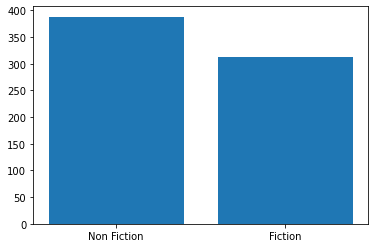

In [11]:
df= pd.DataFrame(book[['Year','Genre']])
counts = df["Genre"].value_counts()
plt.bar(counts.index,counts.values)
plt.show()

([<matplotlib.patches.Wedge at 0x7f6ec0b4b280>,
 [Text(-0.1866898666921769, 1.0840419243158714, 'Non Fiction'),
  Text(0.18668986669217674, -1.0840419243158714, 'Fiction')],
 [Text(-0.10183083637755103, 0.5912955950813843, '55.4%'),
  Text(0.10183083637755094, -0.5912955950813843, '44.6%')])

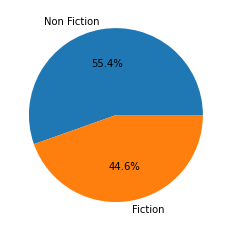

In [12]:
plt.pie(book['Genre'].value_counts(),labels=['Non Fiction','Fiction'],autopct='%.1f%%')

[Text(0.5, 1.0, 'genre distribution')]

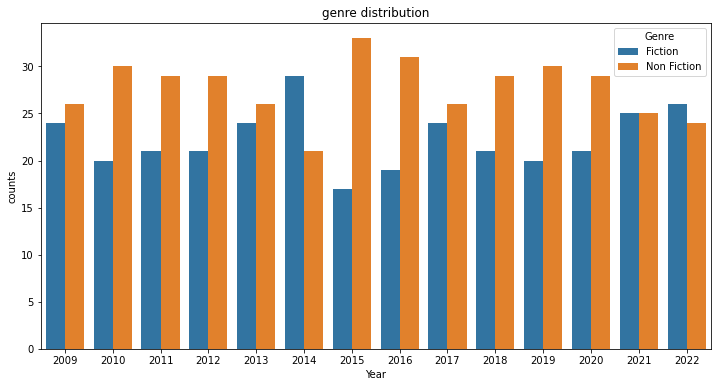

In [13]:
df=book.groupby(['Genre', 'Year']).size().reset_index(name='counts')
plt.figure(figsize=(12, 6))
sns.barplot(x='Year', y='counts', hue='Genre', data=df).set(title='genre distribution')

## IL PREZZO

Un altro interessante studio che si può fare è quello sul prezzo: è aumentato negli anni? è diminuito? il genere incide sul prezzo del libro?

In [14]:
annual_price = book.groupby('Year')[['Price']].mean().sort_values('Year', ascending=True).reset_index()
print(annual_price)

    Year  Price
0   2009  15.40
1   2010  13.48
2   2011  15.10
3   2012  15.30
4   2013  14.60
5   2014  14.64
6   2015  10.42
7   2016  13.18
8   2017  11.38
9   2018  10.52
10  2019  10.08
11  2020  10.46
12  2021  10.78
13  2022  12.46


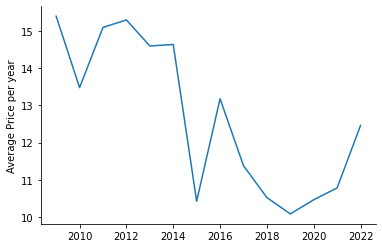

In [15]:
fig, ax = plt.subplots()
plt.plot(annual_price['Year'], annual_price['Price'])
plt.ylabel('Average Price per year')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.show()

Come si nota dal grafico il prezzo è molto variabile ma c'è una tendenza ad un prezzo più alto dal 2009 al 2014
Ora guardiamo se la variazione del costo in base al genere è significativa

[Text(0.5, 1.0, 'genre distribution')]

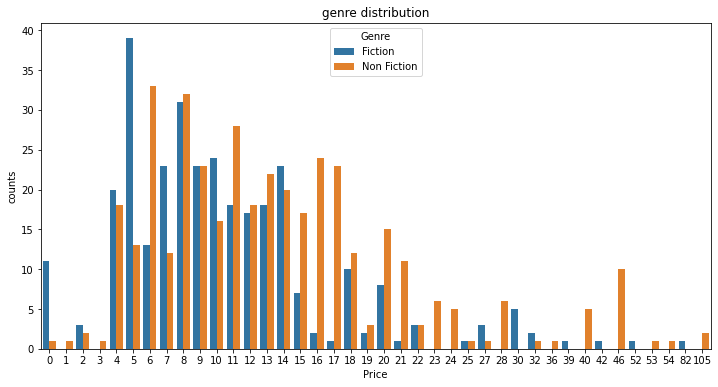

In [16]:
df=book.groupby(['Genre', 'Price']).size().reset_index(name='counts')
plt.figure(figsize=(12, 6))
sns.barplot(x='Price', y='counts', hue='Genre', data=df).set(title='genre distribution')

<AxesSubplot:xlabel='Year', ylabel='Price'>

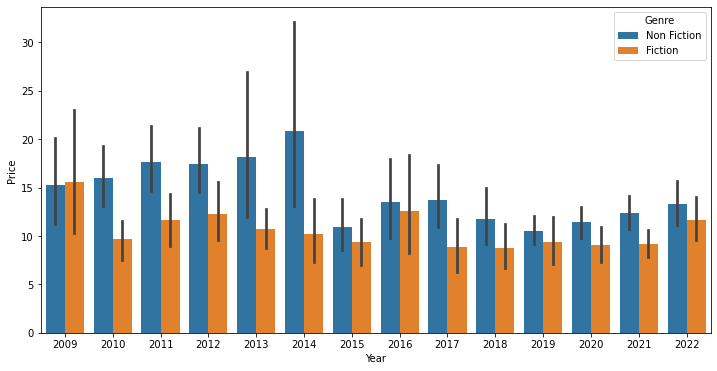

In [17]:
plt.figure(figsize=(12,6))
sns.barplot(data=book, x='Year', y='Price', hue='Genre')

T-test su differenza rating in base al genere
Let's form our hypothesis:

+ H0: There are no significant differences in rating between different genres
+ H1: Different genres have significant different ratings